# Caso #

La divulgación de noticias falsas sobre política a nivel nacional e internacional es una amenaza que puede impactar la gobernabilidad de países y la seguridad global. A nivel interno de un país puede generar polarización y manipulación de la opinión pública debilitando la confianza en instituciones democráticas. Esto puede llevar a influir en elecciones, justificar medidas impopulares entre otras consecuencias. A nivel internacional, estas noticias pueden generar tensiones diplomáticas, influir en decisiones de política exterior y ser usadas en campañas de desestabilización por parte de gobiernos o grupos específicos. Esta reflexión motivó a un grupo de académicos a recolectar y generar noticias con el fin de utilizar aprendizaje automático para facilitar la detección de noticias falsas.

In [1]:
!pip install contractions

In [4]:
!pip install inflect
# Manejo de gráficas
!pip install scikit-plot

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.
ydata-profiling 4.12.2 requires visions[type_image_path]<0.8.0,>=0.7.5, but you have visions 0.7.4 which is incompatible.


In [7]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [8]:
import pandas as pd
import numpy as np
import sys


import re, unicodedata
import contractions
import inflect
import joblib
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.decomposition import PCA, TruncatedSVD
from collections import Counter
from wordcloud import WordCloud
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# 1. Perfilamiento y entendimiento de datos #

In [10]:
datos = pd.read_csv('fake_news_spanish.csv', sep = ';', encoding = 'utf-8')
data = datos.copy()

In [11]:
data.sample(10)

,ID,Label,Titulo,Descripcion,Fecha
22447,ID,1,Moreno recibirá a la familia Caparrós y el PP ...,Vox se queda solo en el Parlamento de Andalucí...,24/11/2022
11422,ID,0,"David de la Cruz, el presidente 'mudo'",En dos semanas ha hecho una declaración de min...,15/06/2018
37985,ID,1,Sánchez: “C's no ha hecho nada en Catalunya y ...,El líder socialista hace un llamamiento a ERC ...,23/05/2018
47963,ID,1,El Govern denuncia ante la Fiscalía la quema d...,"La consellera de la Presidencia, Meritxell Bud...",24/04/2019
47120,ID,1,La 'receta económica' de Casado para afrontar ...,El presidente del PP no ha sabido cuantificar ...,09/03/2020
17462,ID,0,Gallardo declara un patrimonio de más de un mi...,El ex presidente del Gobierno tiene 589.276 eu...,29/09/2018
7482,ID,1,María Jesús Montero: 'Estos Presupuestos dan s...,La ministra de Hacienda critica el sálvense qu...,04/10/2022
46723,ID,1,Irene Montero celebra la ley del 'solo sí es s...,La ministra de Igualdad asegura que trabajarán...,25/08/2022
1967,ID,1,"Fallece a los 92 años Salvador Guzmán, uno de ...",Dedicó su vida a recuperar la memoria de uno d...,07/04/2020
53444,ID,1,Los contagios de coronavirus entre jóvenes ele...,"En las últimas 24 horas, en Catalunya se han r...",03/07/2021


## 1.1 Entendimiento de datos ##

In [12]:
# Descripción
data['Conteo'] = [len(x) for x in data['Descripcion']]
data['Moda'] = [[max(set([len(x) for x in i.split(' ')]), key = [len(x) for x in i.split(' ')].count)][0] for i in data['Descripcion']]
data['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in data['Descripcion']]
data['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in data['Descripcion']]
data

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,218,2,13,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,3251,2,17,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,169,2,13,2
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,133,3,15,2
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,242,2,14,1
...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,244,2,12,1
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,314,3,11,1
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,70,2,11,2
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,232,2,12,1


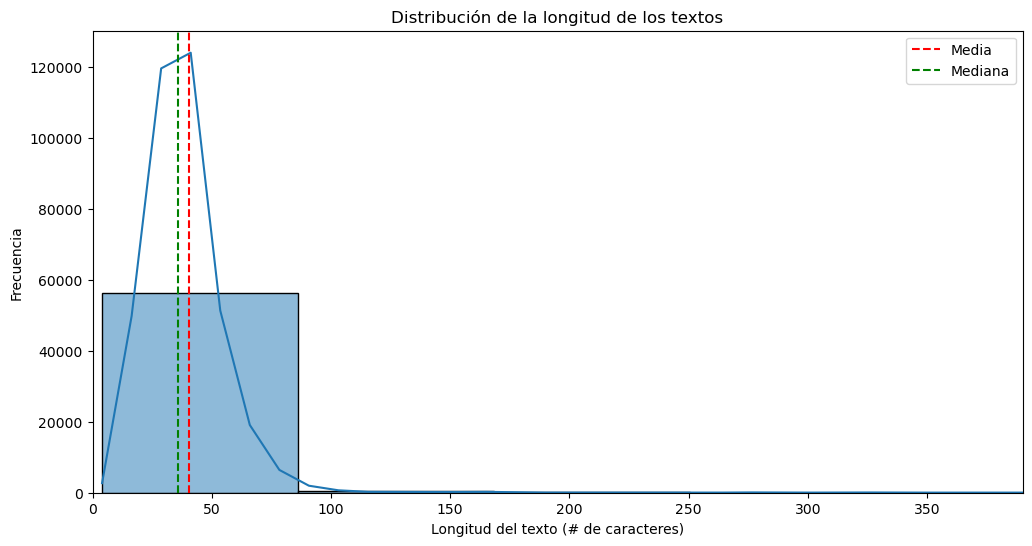

In [13]:
data['text_length'] = data['Descripcion'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.xlim(0, 390)

plt.xlabel('Longitud del texto (# de caracteres)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de los textos')

plt.axvline(x=data['text_length'].mean(), color='red', linestyle='--', label='Media')
plt.axvline(x=data['text_length'].median(), color='green', linestyle='--', label='Mediana')
plt.legend()

plt.show()


Podemos observar que la frecuencia de los textos tiene una alta concentración entre las 0 y 100 palabras, con una disminución progresiva a medida que aumenta el número de palabras. La distribución de palabras en los textos es asimétrica, con una cola larga hacia la derecha.

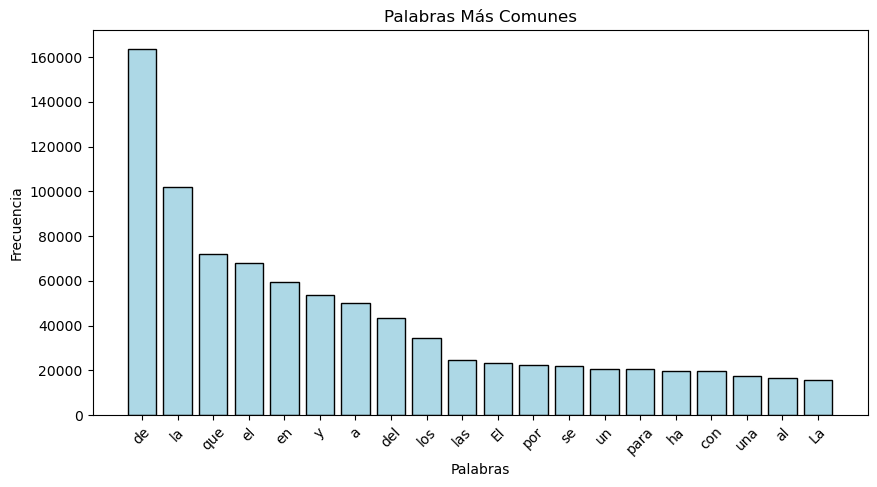

In [14]:
# Contar palabras
word_counts = Counter(data['Descripcion'].str.cat(sep=' ').split())

# Obtener las 20 palabras más comunes
common_words = word_counts.most_common(20)

# Separar palabras y frecuencias
words, counts = zip(*common_words)

plt.figure(figsize=(10,5))
plt.bar(words, counts, color='lightblue', edgecolor='black')
plt.xticks(rotation=45)
plt.title('Palabras Más Comunes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.grid(False)
plt.show()

También observamos que las palabras más comunes son stopwords, por lo que es necesario realizar un preprocesamiento de los datos para eliminarlas.

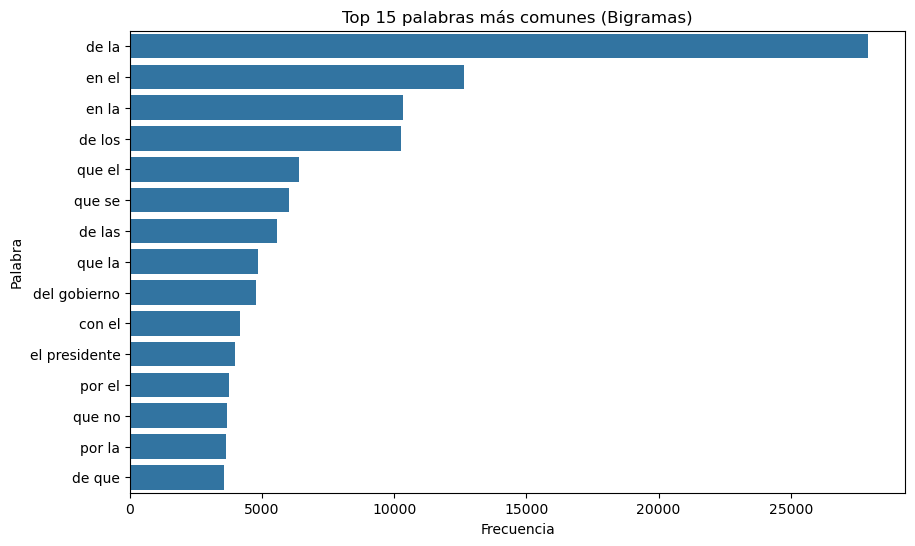

In [15]:
def obtener_palabras_top_n(corpus, n, size):
    vector = CountVectorizer(ngram_range=(size, size)).fit(corpus)
    bolsa_de_palabras = vector.transform(corpus)
    suma_palabras = bolsa_de_palabras.sum(axis=0)
    frecuencias = [(palabra, suma_palabras[0, idx]) for palabra, idx in vector.vocabulary_.items()]
    frecuencias = sorted(frecuencias, key=lambda x: x[1], reverse=True)
    return frecuencias[:n]

palabras_comunes = obtener_palabras_top_n(data['Descripcion'], 15, 2)

palabras = [palabra[0] for palabra in palabras_comunes]
frecuencias = [frecuencia[1] for frecuencia in palabras_comunes]

plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencias, y=palabras)
plt.title('Top 15 palabras más comunes (Bigramas)')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

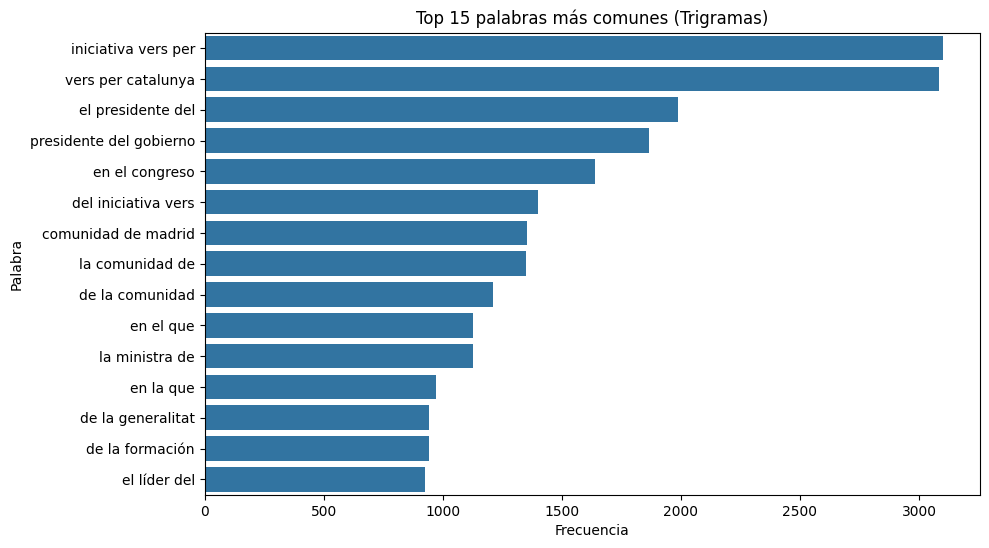

In [13]:
palabras_comunes = obtener_palabras_top_n(data['Descripcion'], 15, 3)

palabras = [palabra[0] for palabra in palabras_comunes]
frecuencias = [frecuencia[1] for frecuencia in palabras_comunes]

plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencias, y=palabras)
plt.title('Top 15 palabras más comunes (Trigramas)')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

Adicionalmente los bigramas más comunes son stopwords, por lo que también es necesario realizar un preprocesamiento de los datos para eliminarlos, sin embargo en cuanto a los trigramas más comunes, estos no son stopwords, si no n-gramas con semántica.

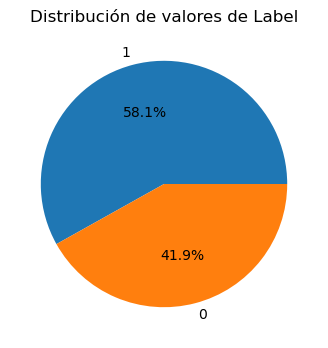

In [15]:
data['Label'].value_counts().plot(kind='pie', figsize=(4, 4), autopct='%1.1f%%')
plt.title('Distribución de valores de Label')
plt.ylabel('')
plt.show()

Finalmente se observa que la distribución de noticias a pesar de ser desbalanceada, no es tan desproporcionada, por lo que no consideramos en un principio necesario realizar un balanceo de clases.

c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30693 (\N{CJK UNIFIED IDEOGRAPH-77E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22696 (\N{CJK UNIFIED IDEOGRAPH-58A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\nbedo\AppData\Local\Programs\Python

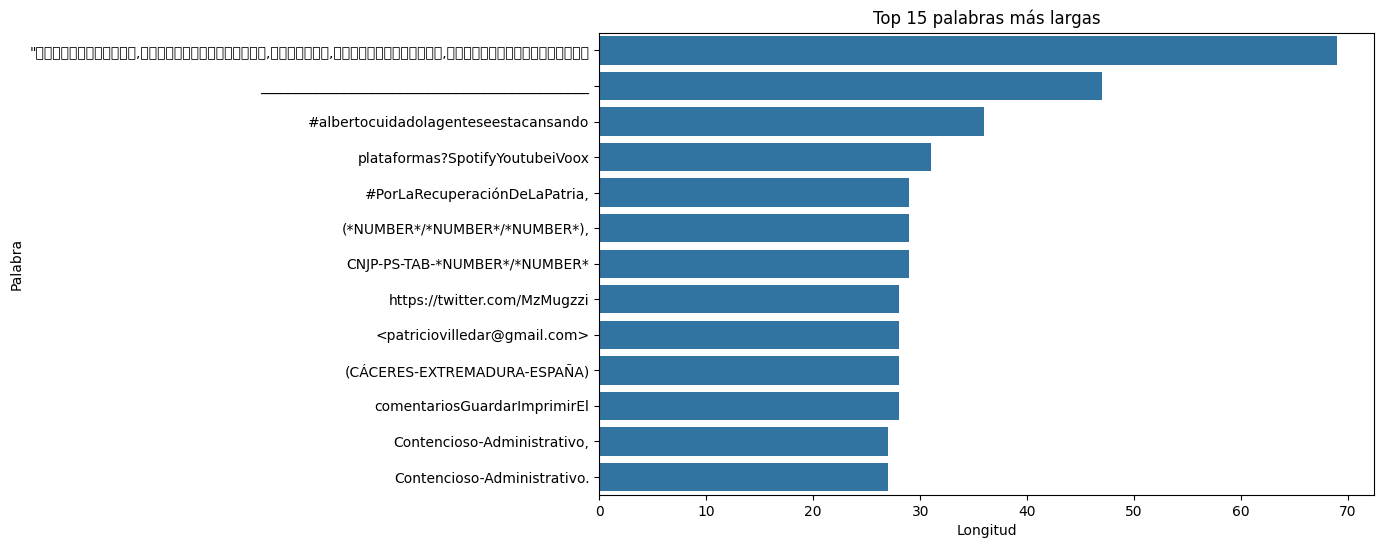

In [14]:
def obtener_top_palabras_largas(corpus, n):
    palabras = ' '.join(corpus).split()
    longitudes = [(palabra, len(palabra)) for palabra in palabras]
    longitudes = sorted(longitudes, key=lambda x: x[1], reverse=True)
    return longitudes[:n]

palabras_largas = obtener_top_palabras_largas(data['Descripcion'], 15)
palabras = [palabra[0] for palabra in palabras_largas]
longitudes = [longitud[1] for longitud in palabras_largas]

plt.figure(figsize=(10, 6))
sns.barplot(x=longitudes, y=palabras)
plt.title('Top 15 palabras más largas')
plt.xlabel('Longitud')
plt.ylabel('Palabra')
plt.show()


De igual forma, las palabras más largas tienen valores ASCII que no corresponden a caracteres alfabéticos, por lo que es necesario realizar un preprocesamiento de los datos para eliminarlos.

## 1.2 Preparación de datos ##

### 1.2.1 Limpieza de datos ###

Declaramos todas las transformaciones que se van a realizar al texto antes de hacer vectorización, buscando reducir los elementos que no aportan información al modelo.

In [17]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        if word is not None:
            new_word = word.lower()
            new_words.append(new_word)
    return new_words
            
def remove_punctuation(words):
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
   p = inflect.engine()
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = p.number_to_words(word)
           new_words.append(new_word)
 
       else:
           new_words.append(word)
   return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    stop_words = set(stopwords.words('spanish'))

    for w in words:
        if w not in stop_words:
            new_words.append(w)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 1.2.2 Análisis Calidad de Datos ###

#### 1.2.2.1 Completitud

In [18]:
data.notnull().mean()

ID             1.00000
Label          1.00000
Titulo         0.99972
Descripcion    1.00000
Fecha          1.00000
Conteo         1.00000
Moda           1.00000
Max            1.00000
Min            1.00000
text_length    1.00000
dtype: float64

Se puede observar que hay títulos de noticias que son nulos, por lo que es necesario realizar un tratamiento de datos para modificarlos

#### Nulos ####

In [19]:
nulo = data[data['Titulo'].isnull()]
nulo

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length
3243,ID,0,NaN,"Hace unos 75 años, Hermann Göring testificó en...",16/06/2019,526,2,24,1,88
4189,ID,0,NaN,"Evidentemente, Barak Obama ha sido arrestado e...",10/03/2022,8322,2,33,0,1341
5041,ID,0,NaN,"""Después de convertirme en presidente, le pedí...",16/03/2022,1762,2,18,1,319
5644,ID,0,NaN,Me pasaron de buena fuente hoy (un vecino del ...,08/04/2023,783,2,36,1,141
7345,ID,0,NaN,Defienden dichos con capitulos de Don Gato.\n\...,02/07/2023,339,2,14,2,56
7652,ID,0,NaN,Lean (y vean la imagen) con mucha atención:\n\...,04/08/2018,3401,2,34,1,582
9700,ID,0,NaN,¿Sabías que Francisco Sagasti salió a marchar ...,26/12/2018,1392,2,14,1,242
15159,ID,0,NaN,Declarar a Bill Gates enemigo público y proces...,02/08/2024,2669,2,55,1,441
19415,ID,0,NaN,Con el fin de captar votos están dispuestos a ...,28/10/2017,844,2,29,0,130
24806,ID,0,NaN,CUANDO LAS IMÁGENES HABLAN MÁS QUE PALABRAS.\n...,28/06/2018,1626,2,22,1,266


Se asignó un espacio vacío para las noticias que no tienen título

In [20]:
data['Titulo'] = data['Titulo'].fillna(' ')

#### 1.2.2.2 Unicidad

Buscamos las noticias con mismo título y descripción

In [21]:
non_empty_rows = data[data['Titulo'] != ' ']
duplicated_rows =  non_empty_rows[non_empty_rows.duplicated(['Titulo', 'Descripcion'], keep=False)].sort_values('Titulo')
duplicated_rows.shape

(882, 10)

Se eliminaron las filas duplicadas

In [22]:
data = data.drop_duplicates(subset = ['Titulo', 'Descripcion'], keep = 'first')
data.shape

(56613, 10)

#### 1.2.2.3 Consistencia

Dado que no contamos con datos categóricos, no se realizaron validaciones de consistencia

#### 1.2.2.4 Validez

Se busca que las fechas cumplan con un mismo formato

In [23]:
data.loc[:,'Fecha'] = pd.to_datetime(data['Fecha'], errors='coerce')

In [24]:
fechas_invalidas = data[data['Fecha'].isna()]
fechas_invalidas

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,NaT,169,2,13,2,30
5,ID,1,"El PNV consolida su mayoría, el PSE salva los ...",Los nacionalistas consiguen las alcaldías de B...,NaT,209,3,14,1,28
6,ID,0,El exconsejero Núria Marín pide el indulto en ...,Sus familiares aluden a su honestidad e integr...,NaT,100,1,10,1,18
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,NaT,197,2,12,2,33
8,ID,1,"José Manuel Pérez Tornero, el creador de la te...",El futuro presidente de RTVE es licenciado en ...,NaT,194,2,12,1,31
...,...,...,...,...,...,...,...,...,...,...
57051,ID,0,"San Chin Choon, a las bases : 'No os afiliéis ...","Durante la Convención Nacional del Ciudadanos,...",NaT,177,2,12,1,27
57052,ID,0,La Mesa consulta a los letrados sobre cómo afe...,No existen precedentes de modificación de las ...,NaT,246,2,15,1,37
57056,ID,1,Iglesias y Puigdemont hablan por teléfono y ac...,El líder de Podemos informa de que ambos han c...,NaT,143,2,11,1,25
57057,ID,0,Polémica por la construcción de un nuevo aerop...,El proyecto de un nuevo aeropuerto genera cont...,NaT,94,2,12,2,14


#### Columnas irrelevantes

La columna ID no aporta información al modelo, por lo que se eliminó

In [25]:
data = data.drop(columns='ID')
data

,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-02-06 00:00:00,218,2,13,1,36
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-01-10 00:00:00,3251,2,17,1,545
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,NaT,169,2,13,2,30
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-03-01 00:00:00,133,3,15,2,20
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-09-03 00:00:00,242,2,14,1,43
...,...,...,...,...,...,...,...,...,...
57058,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-08-06 00:00:00,244,2,12,1,41
57059,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-08-09 00:00:00,314,3,11,1,50
57060,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-12-07 00:00:00,70,2,11,2,11
57061,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,NaT,232,2,12,1,43


### 1.2.3 Tokenización ###

En primer lugar, para la tokenización, se busca eliminar las contracciones

In [26]:
data['Descripcion'] = data['Descripcion'].apply(contractions.fix)
data['Titulo'] = data['Titulo'].apply(contractions.fix) 

Se realiza la tokenización de las palabras para título y descripción

In [27]:
data['words_descripcion'] = data['Descripcion'].apply(word_tokenize)
data['words_titulo'] = data['Titulo'].apply(word_tokenize)
data.head()

,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-02-06 00:00:00,218,2,13,1,36,"[El, diario, británico, publicó, este, pasado,...","['The, Guardian, ', va, con, Sánchez, :, 'Euro..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-01-10 00:00:00,3251,2,17,1,545,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,NaT,169,2,13,2,30,"[El, valencianismo, convoca, en, Castelló, su,...","[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-03-01 00:00:00,133,3,15,2,20,"[En, política, ,, igual, que, hay, que, negoci...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-09-03 00:00:00,242,2,14,1,43,"[En, una, entrevista, en, El, Punt, Avui, ,, e...","[Puigdemont, :, 'No, sería, ninguna, tragedia,..."


Eliminamos los datos que al tokenizar no generan palabras

In [29]:
data['words_descripcion'].dropna()
data['words_titulo'].dropna()

0        ['The, Guardian, ', va, con, Sánchez, :, 'Euro...
1        [REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...
2        [El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...
3        [Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...
4        [Puigdemont, :, 'No, sería, ninguna, tragedia,...
                               ...                        
57058    [El, Defensor, del, Pueblo, reclama, a, la, Co...
57059    [El, EQUO, plantea, ceder, la, presidencia, de...
57060    [Alberto, Garzón, :, 'Que, los, Borbones, son,...
57061    [Vox, exige, entrar, en, el, Gobierno, de, Cas...
57062    [Unas, 300, personas, protestan, contra, la, v...
Name: words_titulo, Length: 56613, dtype: object

Verificamos la no nulidad

In [30]:
data['words_descripcion'].notnull().mean(), data['words_titulo'].notnull().mean()

(1.0, 1.0)

Realizamos el preprocesamiento anteriormente declarado

In [31]:
data['prep_descripcion'] = data['words_descripcion'].apply(preprocessing)
data['prep_titulo'] = data['words_titulo'].apply(preprocessing)

data.head()

,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo,prep_descripcion,prep_titulo
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-02-06 00:00:00,218,2,13,1,36,"[El, diario, británico, publicó, este, pasado,...","['The, Guardian, ', va, con, Sánchez, :, 'Euro...","[diario, britanico, publico, pasado, jueves, e...","[the, guardian, va, sanchez, europa, necesita,..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-01-10 00:00:00,3251,2,17,1,545,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,NaT,169,2,13,2,30,"[El, valencianismo, convoca, en, Castelló, su,...","[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...","[valencianismo, convoca, castello, fiesta, gra...","[ahora, nunca, joan, fuster, estatuto, valenci..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-03-01 00:00:00,133,3,15,2,20,"[En, política, ,, igual, que, hay, que, negoci...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...","[politica, igual, negociar, empresarios, negoc...","[iglesias, alienta, yolanda, diaz, erc, eh, bi..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-09-03 00:00:00,242,2,14,1,43,"[En, una, entrevista, en, El, Punt, Avui, ,, e...","[Puigdemont, :, 'No, sería, ninguna, tragedia,...","[entrevista, punt, avui, lider, jxcat, desdram...","[puigdemont, seria, ninguna, tragedia, repetic..."


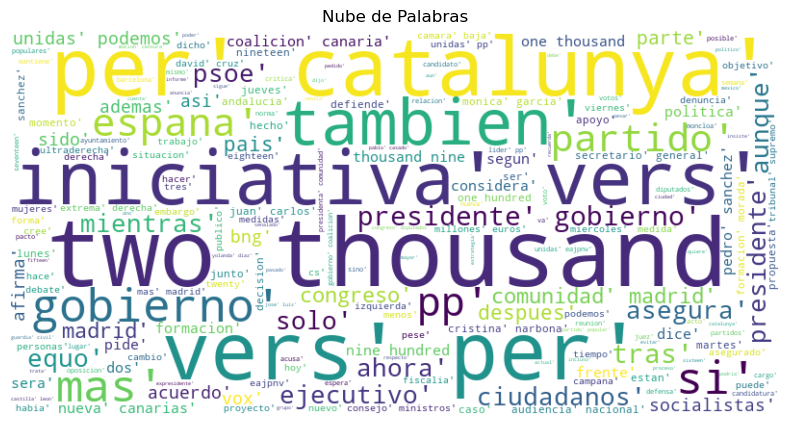

In [27]:
all_text = " ".join(str(t) for t in data['prep_descripcion'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras')
plt.show()


### 1.2.4 Normalización ###

Realizamos stem y lemmatización para las palabras tokenizadas con el fin de reducir la cantidad de palabras y mejorar la calidad de los datos

In [32]:
def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
   stems = stem_words(words)
   lemmas = lemmatize_verbs(words)
   return stems + lemmas


data['prep_descripcion'] = data['prep_descripcion'].apply(stem_and_lemmatize) 
data['prep_titulo'] = data['prep_titulo'].apply(stem_and_lemmatize)
data.head()

,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo,prep_descripcion,prep_titulo
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-02-06 00:00:00,218,2,13,1,36,"[El, diario, británico, publicó, este, pasado,...","['The, Guardian, ', va, con, Sánchez, :, 'Euro...","[diario, britanico, publico, pasado, juev, edi...","[the, guard, va, sanchez, europ, necesit, apue..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-01-10 00:00:00,3251,2,17,1,545,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[revel, gobierno, negocio, liberac, mirel, cam...","[revel, gobierno, negocio, liberac, mirel, cam..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,NaT,169,2,13,2,30,"[El, valencianismo, convoca, en, Castelló, su,...","[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...","[valencianismo, convoc, castello, fiest, grand...","[ahor, nunc, joan, fust, estatuto, valenciano,..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-03-01 00:00:00,133,3,15,2,20,"[En, política, ,, igual, que, hay, que, negoci...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...","[politic, ig, negoci, empresario, negoci, grup...","[iglesia, alient, yoland, diaz, erc, eh, bildu..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-09-03 00:00:00,242,2,14,1,43,"[En, una, entrevista, en, El, Punt, Avui, ,, e...","[Puigdemont, :, 'No, sería, ninguna, tragedia,...","[entrevist, punt, avu, lid, jxcat, desdramatiz...","[puigdemont, ser, ningun, traged, repet, elecc..."


### Selección de campos ###

In [33]:
data['prep_descripcion'] = data['prep_descripcion'].apply(lambda x: ' '.join(map(str, x)))
data['prep_titulo'] = data['prep_titulo'].apply(lambda x: ' '.join(map(str, x)))
data

,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo,prep_descripcion,prep_titulo
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-02-06 00:00:00,218,2,13,1,36,"[El, diario, británico, publicó, este, pasado,...","['The, Guardian, ', va, con, Sánchez, :, 'Euro...",diario britanico publico pasado juev edit prox...,the guard va sanchez europ necesit apuest frut...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-01-10 00:00:00,3251,2,17,1,545,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...",revel gobierno negocio liberac mirel cambio ot...,revel gobierno negocio liberac mirel cambio ot...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,NaT,169,2,13,2,30,"[El, valencianismo, convoca, en, Castelló, su,...","[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...",valencianismo convoc castello fiest grand conm...,ahor nunc joan fust estatuto valenciano cumpl ...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-03-01 00:00:00,133,3,15,2,20,"[En, política, ,, igual, que, hay, que, negoci...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...",politic ig negoci empresario negoci grupo parl...,iglesia alient yoland diaz erc eh bildu negoci...
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-09-03 00:00:00,242,2,14,1,43,"[En, una, entrevista, en, El, Punt, Avui, ,, e...","[Puigdemont, :, 'No, sería, ninguna, tragedia,...",entrevist punt avu lid jxcat desdramatizado po...,puigdemont ser ningun traged repet elecc puigd...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-08-06 00:00:00,244,2,12,1,41,"[El, gobierno, regional, han, indicado, que, l...","[El, Defensor, del, Pueblo, reclama, a, la, Co...",gobierno reg indicado at dia incluyendo at inm...,defens pueblo reclam comunidad madrid dato dem...
57059,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-08-09 00:00:00,314,3,11,1,50,"[Si, la, higiene, democrática, nos, lleva, a, ...","[El, EQUO, plantea, ceder, la, presidencia, de...",si higy democratic llev exigenc ten pas person...,equo plante ced presidenc comunidad madrid cs ...
57060,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-12-07 00:00:00,70,2,11,2,11,"[El, coordinador, federal, de, IU, asegura, qu...","[Alberto, Garzón, :, 'Que, los, Borbones, son,...",coordinad fed iu asegur monarqu putrefact coor...,alberto garzon borbon ladron hecho historica c...
57061,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,NaT,232,2,12,1,43,"[Santiago, Abascal, :, Vox, tiene, el, derecho...","[Vox, exige, entrar, en, el, Gobierno, de, Cas...",santiago abasc vox derecho deb form gobierno c...,vox exig entr gobierno castill leon car vicepr...


### Concatenar título y descripción ###

Dado que ambas columnas contienen información relevante, se concatenan para poder vectorizar una sola columna teniendo en cuenta la información de ambas, esto lo podemos realizar ya que no afectamos el sentido de la noticia.

In [34]:
data["concatenado"] = data["prep_titulo"] + " " + data["prep_descripcion"]
data

,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo,prep_descripcion,prep_titulo,concatenado
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-02-06 00:00:00,218,2,13,1,36,"[El, diario, británico, publicó, este, pasado,...","['The, Guardian, ', va, con, Sánchez, :, 'Euro...",diario britanico publico pasado juev edit prox...,the guard va sanchez europ necesit apuest frut...,the guard va sanchez europ necesit apuest frut...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-01-10 00:00:00,3251,2,17,1,545,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...",revel gobierno negocio liberac mirel cambio ot...,revel gobierno negocio liberac mirel cambio ot...,revel gobierno negocio liberac mirel cambio ot...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,NaT,169,2,13,2,30,"[El, valencianismo, convoca, en, Castelló, su,...","[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...",valencianismo convoc castello fiest grand conm...,ahor nunc joan fust estatuto valenciano cumpl ...,ahor nunc joan fust estatuto valenciano cumpl ...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-03-01 00:00:00,133,3,15,2,20,"[En, política, ,, igual, que, hay, que, negoci...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...",politic ig negoci empresario negoci grupo parl...,iglesia alient yoland diaz erc eh bildu negoci...,iglesia alient yoland diaz erc eh bildu negoci...
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-09-03 00:00:00,242,2,14,1,43,"[En, una, entrevista, en, El, Punt, Avui, ,, e...","[Puigdemont, :, 'No, sería, ninguna, tragedia,...",entrevist punt avu lid jxcat desdramatizado po...,puigdemont ser ningun traged repet elecc puigd...,puigdemont ser ningun traged repet elecc puigd...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57058,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-08-06 00:00:00,244,2,12,1,41,"[El, gobierno, regional, han, indicado, que, l...","[El, Defensor, del, Pueblo, reclama, a, la, Co...",gobierno reg indicado at dia incluyendo at inm...,defens pueblo reclam comunidad madrid dato dem...,defens pueblo reclam comunidad madrid dato dem...
57059,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-08-09 00:00:00,314,3,11,1,50,"[Si, la, higiene, democrática, nos, lleva, a, ...","[El, EQUO, plantea, ceder, la, presidencia, de...",si higy democratic llev exigenc ten pas person...,equo plante ced presidenc comunidad madrid cs ...,equo plante ced presidenc comunidad madrid cs ...
57060,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-12-07 00:00:00,70,2,11,2,11,"[El, coordinador, federal, de, IU, asegura, qu...","[Alberto, Garzón, :, 'Que, los, Borbones, son,...",coordinad fed iu asegur monarqu putrefact coor...,alberto garzon borbon ladron hecho historica c...,alberto garzon borbon ladron hecho historica c...
57061,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,NaT,232,2,12,1,43,"[Santiago, Abascal, :, Vox, tiene, el, derecho...","[Vox, exige, entrar, en, el, Gobierno, de, Cas...",santiago abasc vox derecho deb form gobierno c...,vox exig entr gobierno castill leon car vicepr...,vox exig entr gobierno castill leon car vicepr...


## 1.3 Vectorización de los datos ##

Realizamos la vectorización de los datos, esto después de separar los datos en entrenamiento y prueba, con el fin de evitar data leakage.

In [35]:
vectorizador = TfidfVectorizer()
X = data["concatenado"]
Y = data['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = vectorizador.fit_transform(X_train)
X_test = vectorizador.transform(X_test)


# 2. Modelo 1: SVM #

<small>Modelo implementado por Alejandro Pulido</small>

Decidimos evaluar SVM pues este modelo funciona bien con alta dimensionalidad y es eficiente en la clasificación de texto.

## 2.1 Definición del modelo y cross validation

Hacemos cross validation para poder seleccionar los parametros Kernel y regularización C que mejor se ajusten a los datos

In [72]:
clf = svm.SVC()

param_grid = {
    'kernel' : ['linear', 'poly', 'rbf'],
    'C' : [0.1, 0.5, 0.7],
}

k_folds_knn = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
selector_svm = GridSearchCV(clf, param_grid, scoring='recall', cv=k_folds_knn, verbose=2)

## 2.2 Entrenamiento del modelo ##

Por la alta cantidad de datos, se hace el cross validation con un subconjunto del 25% de los datos

In [75]:
np.random.seed(42)  # Fijar la semilla para reproducibilidad

sample_size = int(0.20 * X_train.shape[0]) 
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)

X_sample = X_train[indices]
Y_sample = Y.iloc[indices]
X_sample.shape, Y_sample.shape

((9058, 65159), (9058,))

In [76]:
selector_svm.fit(X_sample, Y_sample)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  27.9s
[CV] END ...............................C=0.1, kernel=linear; total time=  27.4s
[CV] END ...............................C=0.1, kernel=linear; total time=  27.1s
[CV] END ...............................C=0.1, kernel=linear; total time=  27.1s
[CV] END ...............................C=0.1, kernel=linear; total time=  27.4s
[CV] END .................................C=0.1, kernel=poly; total time=  29.3s
[CV] END .................................C=0.1, kernel=poly; total time=  32.2s
[CV] END .................................C=0.1, kernel=poly; total time=  28.7s
[CV] END .................................C=0.1, kernel=poly; total time=  29.2s
[CV] END .................................C=0.1, kernel=poly; total time=  28.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  30.9s
[CV] END ..................................C=0.1,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 0.7],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='recall', verbose=2)

Finalmente, encontrados los parámetros adecuados, podemos usar el mejor SVM para entrenar con el conjunto completo de datos y posteriormente predecir con el conjunto de prueba

In [77]:
print(f"Mejores hiperparámetros k-NN: {selector_svm.best_params_}")
print(f"Mejor puntaje f1 en validación cruzada: {selector_svm.best_score_}")

Mejores hiperparámetros k-NN: {'C': 0.1, 'kernel': 'linear'}
Mejor puntaje f1 en validación cruzada: 1.0


In [78]:
best_svm = selector_svm.best_estimator_
best_svm.fit(X_train, Y_train)

SVC(C=0.1, kernel='linear')

## 2.3 Evaluación del modelo ##

Finalizado el entrenamiento buscamos analizar qué nos dicen las métricas del modelo

In [79]:
y_pred_best_svm = best_svm.predict(X_test)
f1_test = f1_score(Y_test, y_pred_best_svm)

print("Reporte de clasificación:")
print(classification_report(Y_test, y_pred_best_svm))
print(f"F1-score en el conjunto de prueba: {f1_test:.4f}")

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      4882
           1       0.81      0.99      0.89      6441

    accuracy                           0.86     11323
   macro avg       0.89      0.84      0.85     11323
weighted avg       0.88      0.86      0.86     11323

F1-score en el conjunto de prueba: 0.8895


Para el caso de las noticias falsas se obtuvo una precisión de 0.98 y un recall de 0.69, lo que nos indica que el modelo tiene una alta certeza al momento de encontrar noticias falsas, aunque haya un número considerable de noticias que eran falsas y el modelo no pudo detectar.

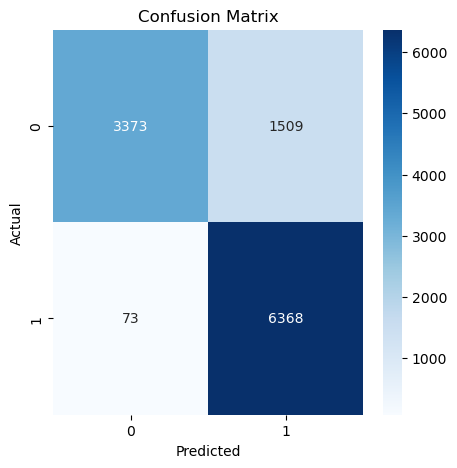

In [ ]:
cm = confusion_matrix(Y_test, y_pred_best_svm)

lt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(selector_svm.best_estimator_, "models/best_model_svm.pkl")  
joblib.dump(selector_svm.best_params_, "models/best_params_svm.pkl")  

La matriz de confusión nos indica que el modelo tiene un mejor desempeño detectando noticias reales que falsas, sin embargo los resultados tienen un buen balance.

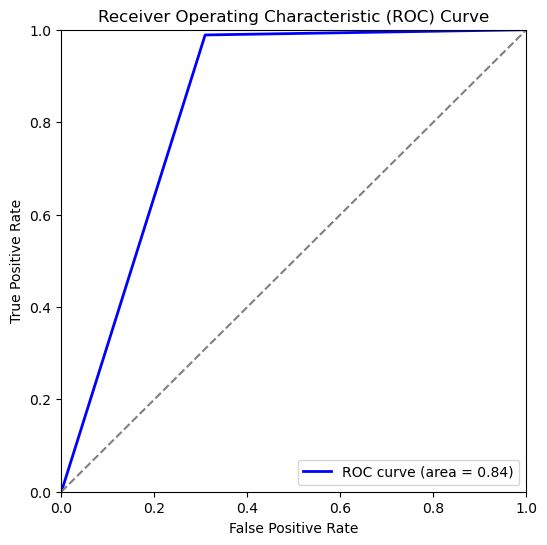

In [82]:
from sklearn.metrics import roc_curve, auc
# Calcular la curva ROC
fpr, tpr, _ = roc_curve(Y_test, y_pred_best_svm)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (azar)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


La curva ROC tiene un área de 0.84, lo que indica que el modelo tiene un buen rendimiento en la clasificación de las noticias, sin embargo esta área tiene margen de mejora, en especial en lo que respecta a los falsos positivos.

# 3. Modelo 2: Regresión Logística #

<small>Modelo implementado por Nicolás Bedoya</small>

Modelo Base

In [38]:
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

Predicciones

In [39]:
Y_train_log = logistic_reg.predict(X_train)
Y_test_log = logistic_reg.predict(X_test)

Métricas

In [40]:
precision_log = precision_score(Y_test, Y_test_log, average=None)
recall_log = recall_score(Y_test, Y_test_log, average=None)
f1_log = f1_score(Y_test, Y_test_log, average=None)
report_log = classification_report(Y_test, Y_test_log, target_names=['Fake', 'Not Fake'], digits=3)

print(report_log)

              precision    recall  f1-score   support

        Fake      0.950     0.808     0.873      4238
    Not Fake      0.879     0.971     0.922      6083

    accuracy                          0.904     10321
   macro avg      0.915     0.889     0.898     10321
weighted avg      0.908     0.904     0.902     10321



Cross Validation

In [42]:
param_grid_log = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1]
}

log_reg = LogisticRegression(solver='saga', max_iter=1000)

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid_log, cv=4, scoring='f1_macro')
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

joblib.dump(grid_search.best_estimator_, "best_model_log.pkl")  
joblib.dump(grid_search.best_params_, "best_params_log.pkl")    

print("Best Parameters:", best_params)

c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

Best Parameters: {'C': 1, 'penalty': 'l1'}


c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [3]:
best_model = joblib.load("models/best_model_log.pkl")
best_params = joblib.load("models/best_params_log.pkl")

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
best_model.fit(X_train, Y_train)

c:\Users\nbedo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

In [45]:
Y_pred_train_logcv = best_model.predict(X_train)
Y_pred_test_logcv = best_model.predict(X_test)
classification_report_logcv = classification_report(Y_test, Y_pred_test_logcv)
f1_score_logcv = f1_score(Y_test, Y_pred_test_logcv)

print(classification_report_logcv)
print(f'F1 score: {f1_score_logcv}')

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      4238
           1       0.90      0.96      0.93      6083

    accuracy                           0.92     10321
   macro avg       0.92      0.90      0.91     10321
weighted avg       0.92      0.92      0.91     10321

F1 score: 0.9307009197589597


Matriz de confusión

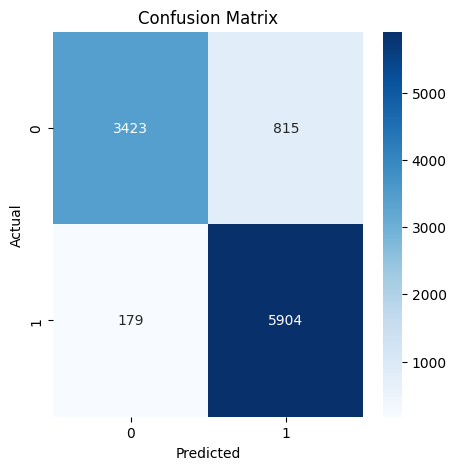

In [57]:
cm_logcv = confusion_matrix(Y_test, Y_pred_test_logcv)

plt.figure(figsize=(5,5))
sns.heatmap(cm_log, cmap='Blues', annot=True, fmt='g', xticklabels=set(Y_test), yticklabels=set(Y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

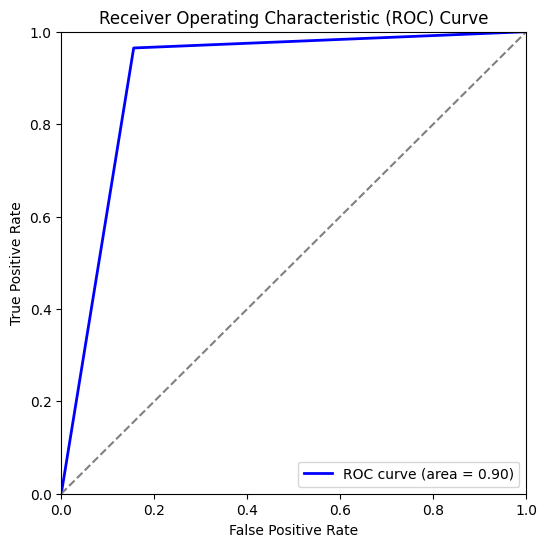

In [46]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred_test_logcv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (azar)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 4. Modelo 3: Random Forest #

## 4.1 Definición del modelo y cross validation

<small>Modelo implementado por Guliana Volpi</small>

In [47]:
random_forest = RandomForestClassifier(random_state = 42)

Por la alta cantidad de datos, se hace el cross validation con un subconjunto del 25% de los datos

In [48]:
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train)
Y_train_df = pd.Series(Y_train)

X_train_sample = X_train_df.sample(frac=0.25, random_state=42)
Y_train_sample = Y_train_df.iloc[X_train_sample.index]

Hacemos cross validation para poder seleccionar los hiperaprámetros `n_estimators`, `max_depth`, `min_samples_split` que mejor se ajusten a los datos

In [49]:
hiperparametros_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 15, 20]
}

k_folds_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
selector_rf = GridSearchCV(estimator = random_forest, param_grid = hiperparametros_rf, cv=k_folds_rf, scoring='f1', verbose=1)

## 4.2 Entrenamiento del modelo ##

In [50]:
selector_rf.fit(X_train, Y_train)

print('Mejores hiperparámetros : ', selector_rf.best_params_)
print('Mejors puntaje F1: ', selector_rf.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros :  {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 100}
Mejors puntaje F1:  0.863687048082355


## 4.3 Evaluación del modelo ##

In [51]:
mejor_modelo_rf = selector_rf.best_estimator_

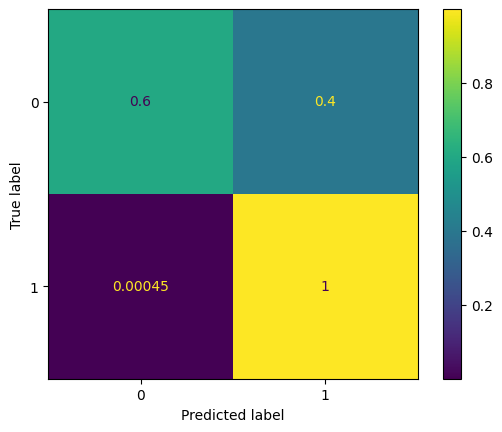

In [61]:
Y_pred_train_rf = mejor_modelo_rf.predict(X_train)
Y_pred_test_rf = mejor_modelo_rf.predict(X_test)

matriz_confusion_train_rf = confusion_matrix(Y_train, Y_pred_train_rf, labels=mejor_modelo_rf.classes_, normalize='true')
matriz_train_rf = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_train_rf, display_labels=mejor_modelo_rf.classes_)  
matriz_train_rf.plot()

In [62]:

print(classification_report(Y_test, Y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.99      0.57      0.72      4238
           1       0.77      1.00      0.87      6083

    accuracy                           0.82     10321
   macro avg       0.88      0.78      0.80     10321
weighted avg       0.86      0.82      0.81     10321



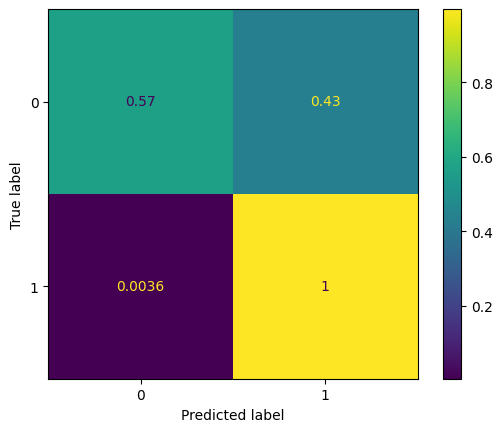

In [ ]:


matriz_confusion_rf = confusion_matrix(Y_test, Y_pred_test_rf, labels=mejor_modelo_rf.classes_, normalize='true')
matriz_rf = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_rf, display_labels=mejor_modelo_rf.classes_)  
matriz_rf.plot()

In [63]:
print(classification_report(Y_test, Y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.99      0.57      0.72      4238
           1       0.77      1.00      0.87      6083

    accuracy                           0.82     10321
   macro avg       0.88      0.78      0.80     10321
weighted avg       0.86      0.82      0.81     10321



In [56]:
joblib.dump(selector_rf.best_estimator_, "best_model_rf.pkl")  
joblib.dump(selector_rf.best_params_, "best_params_rf.pkl")    


['best_params_rf.pkl']

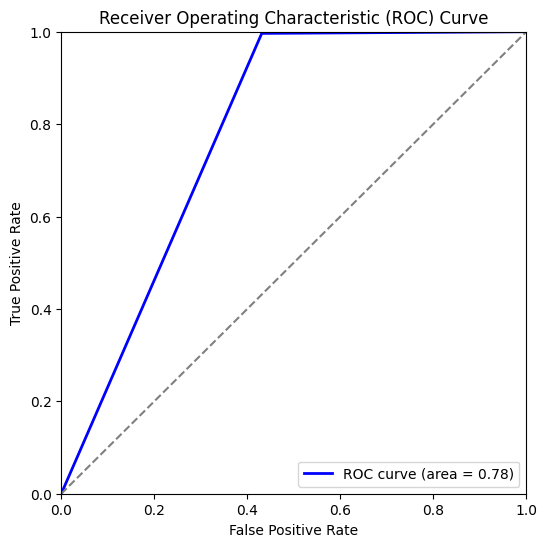

In [64]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred_test_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (azar)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 5. Resultados #

## 5.1 Resultados del mejor modelo

In [3]:
import joblib
selected_model = joblib.load("models/best_model_log.pkl")

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [39]:
selected_model.fit(X_train, Y_train)

/usr/local/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

In [42]:
precision_log = precision_score(Y_test, Y_pred_test_logcv, average=None)
recall_log = recall_score(Y_test, Y_pred_test_logcv, average=None)
f1_log = f1_score(Y_test, Y_pred_test_logcv, average=None)
report_log = classification_report(Y_test, Y_pred_test_logcv, target_names=['Fake', 'Not Fake'], digits=3)

print(report_log)

              precision    recall  f1-score   support

        Fake      0.945     0.847     0.893      4882
    Not Fake      0.892     0.962     0.926      6441

    accuracy                          0.913     11323
   macro avg      0.919     0.905     0.910     11323
weighted avg      0.915     0.913     0.912     11323



Encontramos que para el mejor modelo las métricas indican que el modelo va a tener una mayor certeza al momento de etiquetar noticias falsas, sin embargo, el recall es más bajo, por lo que es posible que pasen noticias falsas que el modelo no detecte.

En cuanto a las noticias reales, el modelo tiene un mayor recall, por lo que es más poco probable que pase una noticia real que el modelo detecte como falsa

## 5.2 Palabras más significativas

In [58]:
feature_names = np.array(vectorizador.get_feature_names_out())
coef = best_model.coef_[0]
word_importance = dict(zip(feature_names, coef))

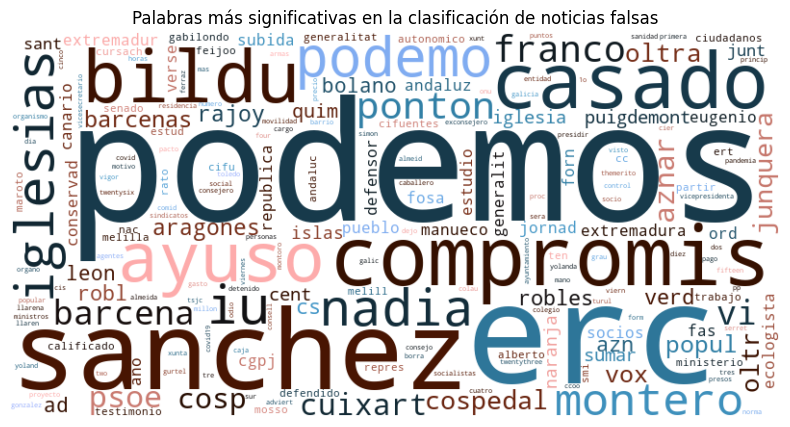

In [59]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='berlin').generate_from_frequencies(word_importance)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Palabras más significativas en la clasificación de noticias falsas")
plt.show()

Las palabrás más signifcativas en la clasificación de noticias falsas son relacionadas a entidades políticas de España

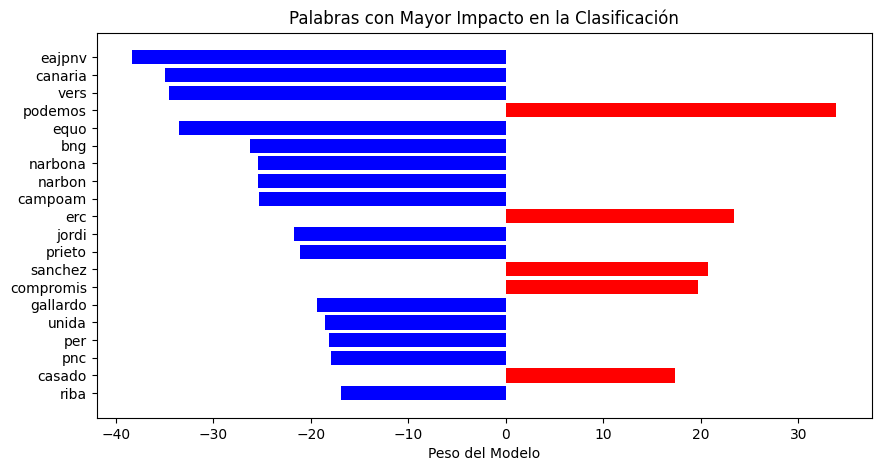

In [60]:

sorted_indices = np.argsort(np.abs(coef))[::-1][:20]  
top_words = feature_names[sorted_indices]
top_coefficients = coef[sorted_indices]

plt.figure(figsize=(10, 5))
plt.barh(top_words[::-1], top_coefficients[::-1], color=['red' if x > 0 else 'blue' for x in top_coefficients[::-1]])
plt.xlabel("Peso del Modelo")
plt.title("Palabras con Mayor Impacto en la Clasificación")
plt.show()

Las palabras graficadas son las que tienen un mayor peso en el modelo de la regresión logística. Las palabras azules (< 0) significan que están menos relacionadas con las noticias falsa, mientras que las palabras rojas (> 0) estpan más relacionadas con noticias falsas.

## 5.3 Inferencia en datos de prueba compartidos

In [ ]:
shared_data = pd.read_csv('fake_news_spanish.csv', sep = ';', encoding = 'utf-8')